In [1]:
import numpy as np
import os

In [2]:
from pathlib import Path

try:
    import numpy as np
except Exception as e:
    print(e)
    %pip install numpy
    import numpy as np


try:
    from plotly.subplots import make_subplots
    import plotly.graph_objects as go
except Exception as e:
    print(e)
    %pip install plotly
    from plotly.subplots import make_subplots
    import plotly.graph_objects as go
    

#### Setting up

In [3]:
# taken from the default output .ipynb

path_to_recording = os.path.join(os.getcwd(), "recording_17_09_28_gmt-4") #"C:\\Users\\briid\\Documents\\Research\\Arm-Simulation-with-Forces\\experimentation\\freemocap\\recording_19_56_30_gmt-4"


bodypart = 'left_index'
mediapipe_indices = ['nose',
'left_eye_inner',
'left_eye',
'left_eye_outer',
'right_eye_inner',
'right_eye',
'right_eye_outer',
'left_ear',
'right_ear',
'mouth_left',
'mouth_right',
'left_shoulder',
'right_shoulder',
'left_elbow',
'right_elbow',
'left_wrist',
'right_wrist',
'left_pinky',
'right_pinky',
'left_index',
'right_index',
'left_thumb',
'right_thumb',
'left_hip',
'right_hip',
'left_knee',
'right_knee',
'left_ankle',
'right_ankle',
'left_heel',
'right_heel',
'left_foot_index',
'right_foot_index']

joint_to_plot_index = mediapipe_indices.index(bodypart)


path_to_recording = Path(path_to_recording)
path_to_center_of_mass_npy = path_to_recording/'output_data'/'center_of_mass'/'total_body_center_of_mass_xyz.npy'
path_to_freemocap_3d_body_data_npy = path_to_recording/'output_data'/'mediapipe_body_3d_xyz.npy'

freemocap_3d_body_data = np.load(path_to_freemocap_3d_body_data_npy)
total_body_com_data = np.load(path_to_center_of_mass_npy)

In [4]:
# get indices for body parts
def get_index(body_part = 'left_wrist'):
    return mediapipe_indices.index(body_part)

In [5]:
# function to get data for particular body part
def get_bodypart_data(bodypart = "left_index"):
    
    joint_to_plot_index = mediapipe_indices.index(bodypart)

    return freemocap_3d_body_data[:,joint_to_plot_index,:]

In [6]:
# function to get distance between two body parts
# parameters are the data arrays for the body parts
# returns array of distances between parts
def dist_between_vertices(first_part, second_part):
    cur_dist = np.ndarray(shape = first_part.shape, dtype = first_part.dtype)
    for i in range(0, len(first_part) - 1):     # get the distance for each frame of the video (excluding last frame)
        cur_dist[i] = np.linalg.norm(first_part[i] - second_part[i])
        #print(cur_dist[i])]
    return cur_dist[:-1, 0]

In [7]:
# ratio between current length and zero length:
left_hand_to_elbow_array = dist_between_vertices(get_bodypart_data("left_index"), get_bodypart_data("left_elbow"))

In [8]:
# get median of largest distances between vertices/bodyparts
def max_dist_between_parts(dist_array):
    ind = (np.argpartition(dist_array, -20)[-20:-5])
    return np.median(dist_array[ind])

In [9]:
# get approximate distance between vertices/body parts
left_hand_to_elbow_dist = max_dist_between_parts(left_hand_to_elbow_array)
print(left_hand_to_elbow_dist)

273.71819753609157


##### Height

In [10]:
# get ratio to real distance in meters
real_height_metric = 1.78     # meters
sim_wingspan = np.max(dist_between_vertices(get_bodypart_data("left_index"), get_bodypart_data("right_index")))     # max distance between wrists via `freemocap`

sim_to_real_conversion_factor = real_height_metric / sim_wingspan
print(sim_to_real_conversion_factor)

0.0018942132407265607


In this case, we have acquired a sim-to-real (metric) conversion factor of approximately `0.0018990637829`.

For a roughly approximate method of checking the validity of the conversion factor, we will calculate the distance from the eyes (`left_eye` and `right_eye`) to the heels (`left_heel` and `right_heel`).

***Keep in mind, the full body was not in frame for this run at any point, so this estimate is going to be off by a decent margin. This was done for experimentation purposes only.***

In [11]:
# get data for eyes and heels
left_eye_data = get_bodypart_data("left_eye")
right_eye_data = get_bodypart_data("right_eye")
left_heel_data = get_bodypart_data("left_heel")
right_heel_data = get_bodypart_data("right_heel")

In [12]:
# calculate distance for each side, then divide by 2 to get the average of the two
height_approx_left = np.max(dist_between_vertices(left_eye_data, left_heel_data))
height_approx_right = np.max(dist_between_vertices(right_eye_data, right_heel_data))
rough_approx_height_sim = (height_approx_left + height_approx_right) / 2

In [13]:
rough_approx_height = rough_approx_height_sim * sim_to_real_conversion_factor
print("%s meters" % rough_approx_height)

2.5552095594444317 meters


Not great, but only a little less than 25% off from the real value, so not too terrible. Let's try something more reasonable, like the length of one arm.

In [14]:
left_shoulder_data = get_bodypart_data("left_shoulder")
right_shoulder_data = get_bodypart_data("right_shoulder")
np.max(left_shoulder_data)

940.1174044583802

In [15]:
right_index_data = get_bodypart_data("right_index")
left_index_data = get_bodypart_data("left_index")

In [16]:
# right hand to shoulder
print("%s meters" % (np.max(dist_between_vertices(right_shoulder_data, right_index_data)) * sim_to_real_conversion_factor))

0.9861484383539701 meters


In [17]:
# left hand to shoulder
print("%s meters" % (np.max(dist_between_vertices(left_index_data, left_shoulder_data)) * sim_to_real_conversion_factor))

0.9828567887338504 meters


### Trying to do depth:

In [18]:
# calculate the angle of the segment (body part) from the normal (where it is longest)
def angle_from_normal(cur_dist, max_dist):
    return np.arccos(cur_dist / max_dist)

In [19]:
angle_from_normal(0, left_hand_to_elbow_dist)

1.5707963267948966

Nice! The output, `1.570796`, is half of pi, or pi/2. This is exactly what we were looking for when the cur_dist is 0, telling us that it works as expected.

Now, use this to calculate the distance the (body part) vertex is away from the norm with the angle, and there's your depth.

In [20]:
test_vertex_one = get_bodypart_data('left_index')
test_vertex_two = get_bodypart_data('left_elbow')
test_dist_array = dist_between_vertices(test_vertex_one, test_vertex_two)

test_dist_array = test_dist_array
test_max_dist = max_dist_between_parts(test_dist_array)
test_angle = angle_from_normal(test_dist_array[13], test_max_dist)
test_depth = np.sin(test_angle) * test_max_dist
print(test_angle)
print(test_depth)

0.7248802476831095
181.48770218195213


In [21]:
# get depth
def get_depth(vertex_one, vertex_two):
    dist_array = dist_between_vertices(vertex_one, vertex_two)
    max_dist = max_dist_between_parts(dist_array)
    depths = list()
    for frame in dist_array:
        angle = angle_from_normal(frame, max_dist)
        depths.append(np.sin(angle) * max_dist)
    return depths

In [22]:
np.nan_to_num(get_depth(get_bodypart_data('left_index'), get_bodypart_data('left_elbow')))#, 10))

C:\Users\briid\AppData\Local\Temp\ipykernel_20548\1837775029.py:3: RuntimeWarning: invalid value encountered in arccos
  return np.arccos(cur_dist / max_dist)


array([201.16818931, 191.44140269, 185.8875152 , ..., 170.18153525,
       169.16309666, 168.85585668])

In [23]:
# put together pairs for each of the vertices
# ordered in a particular manner which uses the shoulders as anchors for the elbows, and elbows as anchors for the wrists
vertex_order = [
    [
        'left_shoulder',
        'right_shoulder'
    ],
    [
        'left_shoulder',
        'left_elbow',
        'left_wrist',
    ],
    [
        'right_shoulder',
        'right_elbow',
        'right_wrist'
    ]
]

In [24]:
# get y axes by order of body parts
def get_y_axes(vertex_order = vertex_order):
    y = list()
    for vertices in vertex_order:
        group_y = list()
        num_vertices = len(vertices)
        for i, vertex in enumerate(vertices):
            if i < (num_vertices - 1):
                y_dist_between_vertices = np.nan_to_num(get_depth(get_bodypart_data(vertices[i]), get_bodypart_data(vertices[i + 1])))
                if i > 0:
                    vertex_y = group_y[i - 1] +  y_dist_between_vertices    # add y depth of anchor to current
                else:
                    vertex_y = y_dist_between_vertices
                group_y.append(vertex_y)
        y.append(group_y)
    return y

In [25]:
# test get_y_axes
print(get_y_axes())

[[array([170.34470952, 167.84927604, 164.02507427, ..., 136.04569482,
       135.67595821, 135.83306117])], [array([162.3287202 , 152.95185978, 147.38580189, ...,   0.        ,
         0.        ,   0.        ]), array([323.79095531, 306.94230571, 297.06635083, ..., 130.77762345,
       129.82227333, 129.17114325])], [array([30.48527489, 56.62963244, 52.78968425, ...,  0.        ,
        0.        ,  0.        ]), array([175.88890367, 198.93353679, 197.33366678, ...,  56.26485417,
        65.36570067,  90.02990625])]]


C:\Users\briid\AppData\Local\Temp\ipykernel_20548\1837775029.py:3: RuntimeWarning: invalid value encountered in arccos
  return np.arccos(cur_dist / max_dist)


In [26]:
# get y axes
y_axes = get_y_axes()
# account for difference between shoulder y-axes
y_axes[2] += y_axes[0]  # by adding it to the branch off the right shoulder

C:\Users\briid\AppData\Local\Temp\ipykernel_20548\1837775029.py:3: RuntimeWarning: invalid value encountered in arccos
  return np.arccos(cur_dist / max_dist)


In [27]:
# put together dictionary coordinating everything
depth_dict = {
    'vertex_order': vertex_order,                # pairs of body parts/segments
    'y_axes': y_axes,   # approximated depth
}

### Finishing up depth (on y-axis)

In [28]:
# get indices for body parts used
indices = list()
for vertices in depth_dict['vertex_order']:
    for vertex in vertices:
        indices.append(get_index(vertex))

print(indices)

[11, 12, 11, 13, 15, 12, 14, 16]


In [29]:
# approximate depth for the video recording
def set_depth(depth_dict = depth_dict, body_data = freemocap_3d_body_data):
    depth_body_data = body_data[:, :, 1]    # y axis of each part on each frame

    # go through and set y-axes values accordingly
    for i, order_group in enumerate(depth_dict['y_axes']):
        cur_length = len(depth_dict['vertex_order'][i])
        # go thru all vertices in current group
        for j, vertex in enumerate(order_group):
            if j < (cur_length - 1):
                # set y axis for each vertex in the order group
                cur_vertex = depth_dict['vertex_order'][i][j + 1]   # + 1 so that it applies to the non-anchor vertex
                vertex_index = mediapipe_indices.index(cur_vertex)
                body_data[:, vertex_index, 1] = np.append(vertex, 0)

    body_data[:, :, 1] = depth_body_data
    return body_data

In [30]:
# testing...
test_body_data = set_depth(body_data = freemocap_3d_body_data)

In [31]:
# original data
print(freemocap_3d_body_data[:, 13, 1]) # printing elbow data for y axis over time

[162.3287202  152.95185978 147.38580189 ...   0.           0.
   0.        ]


In [ ]:
# same data, but in test_body_depth (depth calculated and applied)
print(test_body_data[:, 13, 1]) # printing elbow data for y axis over time

[162.3287202  152.95185978 147.38580189 ...   0.           0.
   0.        ]


In [32]:
# set the depth:
freemocap_3d_body_data = set_depth(body_data = freemocap_3d_body_data)

### Elbow angle

In [34]:
print(freemocap_3d_body_data[:, 11, 0])

[825.79040925 826.07841435 827.71103097 ... 939.66680248 939.58719962
 940.11740446]


In [35]:
# get max length of segments/body parts
upper_arm_max_length = max_dist_between_parts(dist_between_vertices(freemocap_3d_body_data[:, 11, :], freemocap_3d_body_data[:, 13, :]))
lower_arm_max_length = max_dist_between_parts(dist_between_vertices(freemocap_3d_body_data[:, 13, :], freemocap_3d_body_data[:, 15, :]))
print(upper_arm_max_length * sim_to_real_conversion_factor)
print(lower_arm_max_length * sim_to_real_conversion_factor)

0.4813700689084789
0.41905808119504173


In [36]:
# not scientific notation
np.set_printoptions(suppress = True, precision = 3)

#### Getting angle at elbow

In [37]:
# get x y and z for spherical coordinate transformations/angle getting
# x and y axes aligned with body data tensor
x = freemocap_3d_body_data[:, 11:17:2, 0] 
y = freemocap_3d_body_data[:, 11:17:2, 1]
z = freemocap_3d_body_data[:, 11:17:2, 2]

In [38]:
# calculate vectors for getting angle at elbow
vector_a = [(x[:, 0] - x[:, 1]), (y[:, 0] - y[:, 1]), (z[:, 0] - z[:, 1])]
vector_b = [(x[:, 2] - x[:, 1]), (y[:, 2] - y[:, 1]), (z[:, 2] - z[:, 1])]

forearm_length = np.sqrt( (vector_b[0] ** 2) + (vector_b[1] ** 2) + (vector_b[2] ** 2) )
upperarm_length = np.sqrt( (vector_a[0] ** 2) + (vector_a[1] ** 2) + (vector_a[2] ** 2) )

elbow_angle = np.arccos( ( (vector_a[0] * vector_b[0]) + (vector_a[1] * vector_b[1]) + (vector_a[2] * vector_b[2]) ) / (forearm_length * upperarm_length) )

In [39]:
# calculate vectors for getting angle at shoulder

# create new "vertex" at shoulder - 1 (arbitrary number) on z-axis for getting angle at shoulder, orientation agnostic
# x and y will be the same as shoulder, z will be slightly different
z_w = z[:, 0] - 1

# vectors
# hence, wrist vertex will be unused here; replace all 1s with 0s, all 2s with 1s, and all z[:, 0]s with z_w
# all x[:, 0] will be the same no matter what, since those values for the shoulder and the new vertex will be exactly the same; hence, no need for a new one
vector_c = [(x[:, 0] - x[:, 0]), (y[:, 0] - y[:, 0]), (z_w - z[:, 0])]
vector_d = [(x[:, 1] - x[:, 0]), (y[:, 1] - y[:, 0]), (z[:, 1] - z[:, 0])]

uarm_length = np.sqrt( (vector_d[0] ** 2) + (vector_d[1] ** 2) + (vector_d[2] ** 2) )
w_length = np.sqrt( (vector_c[0] ** 2) + (vector_c[1] ** 2) + (vector_c[2] ** 2) )

# shoulder angle
shoulder_arm_angle = np.arccos( ( (vector_c[0] * vector_d[0]) + (vector_c[1] * vector_d[1]) + (vector_c[2] * vector_d[2]) ) / (w_length * uarm_length) )

Now put it in the data matrix for display by plotly

In [40]:
freemocap_3d_body_data[:, 30, :] = np.swapaxes(vector_a, 0, 1)  # swapped axes due to shape of 2D array
freemocap_3d_body_data[:, 31, :] = np.swapaxes(vector_b, 0, 1)

freemocap_3d_body_data[:, 32, 0] = forearm_length * sim_to_real_conversion_factor
freemocap_3d_body_data[:, 32, 1] = upperarm_length * sim_to_real_conversion_factor
freemocap_3d_body_data[:, 32, 2] = elbow_angle

#### Getting spherical coordinates

In [41]:
# get spherical coordinates for each of the 3 vertices (bodyparts) of interest, 
#   and set them to overwrite parts 27-29 of freemocap_3d_body_data for displaying with `plotly`

# initialize to x.shaped ndarray since x is conveniently the same shape we want
rho = np.zeros(x.shape)
theta = np.zeros(x.shape)
phi = np.zeros(x.shape)

# set for [elbow, wrist]    using difference between current point and shoulder point
for vertex in [1, 2]:       # using shoulder as origin, running for elbow (1) and wrist (2)
    if vertex == 1:     # if elbow (from shoulder to elbow)
        cur_shoulder = freemocap_3d_body_data[:, 11, :]     # shoulder
    elif vertex == 2:   # if wrist (from elbow to wrist)
        cur_shoulder = freemocap_3d_body_data[:, 13, :]     # elbow
    cur_bodypart = freemocap_3d_body_data[:, (11 + (vertex * 2) ), :]
    
    # effectively sets origin to cur_shoulder
    x_diff = cur_bodypart[:, 0] - cur_shoulder[:, 0]
    y_diff = cur_bodypart[:, 1] - cur_shoulder[:, 1]
    z_diff = cur_bodypart[:, 2] - cur_shoulder[:, 2]

    rho[:, vertex] = np.sqrt((x_diff ** 2) + (y_diff ** 2) + (z_diff ** 2))
    theta[:, vertex] = np.arctan(y_diff / x_diff)   # swapped due to equations having different Cartesian coordinate system layout
    phi[:, vertex] = np.arccos(z_diff / rho[:, vertex])

In [42]:
# put spherical coords in bodydata matrix for displaying in the model 
freemocap_3d_body_data[:, 27, :] = rho
freemocap_3d_body_data[:, 28, :] = theta    # 
freemocap_3d_body_data[:, 29, :] = phi      # z / rho^2

# the data at the parts of the freemocap_3d_body_data tensor used here are not actual for body parts (anymore), but places to hold information
# for simplification for displaying via plotly, which is used by freemocap, hence its continued use here

In [43]:
# get arm lengths from 
forearm_len = freemocap_3d_body_data[:, 32, 0]
upperarm_length = freemocap_3d_body_data[:, 32, 1]

rho = freemocap_3d_body_data[:, 27, :] * sim_to_real_conversion_factor

h_p = 1.75    # meters      # height of person
w_p = 90      # kilograms   # weight of person
w_bal = 3     # kilograms   # weight of ball


In [44]:
# equations used primarily from the paper labeled "shoulderarm3.pdf" in the dropbox, as wel as some info from emails betwee Dr. Liu and I (Bri)

w_fa = w_p * 0.023                      # weight of forearm
cgf = h_p * 0.432 * 0.216               # center of gravity of forearm
f = h_p * 0.216                         # length of forearm
b = h_p * 0.11                          # dist between elbow and bicep insertion point
u = h_p * 0.173                         # length of upper arm

theta_arm = phi[:, 1] - (np.pi / 2)                         # angle at shoulder
theta_u = elbow_angle                                       # angle at elbow
theta_b = np.pi - ( (b - u * np.cos(theta_u)) / np.sqrt( (b ** 2) + (u ** 2) - 2 * b * u * np.cos(theta_u) ) )      # angle at bicep insertion point
theta_la = np.sin(theta_u + theta_arm - (np.pi / 2))        # angle used for leverage arms fa and bal

la_fa = cgf * theta_la                                      # forearm lever arm
la_bal = f * theta_la                                       # ball lever arm
la_bic = b * np.sin(theta_b)                                # bicep lever arm

force_bicep = (w_fa * la_fa + w_bal * la_bal) / la_bic      # force applied by bicep muscle

In [45]:
# prep for visual in plotly output

# theta-arm, bicep force, theta-u
freemocap_3d_body_data[:, 26, 0] = np.rad2deg(theta_arm)
freemocap_3d_body_data[:, 26, 1] = force_bicep 
freemocap_3d_body_data[:, 26, 2] = np.rad2deg(elbow_angle)

# rho, theta, phi
freemocap_3d_body_data[:, 27, :] = rho
freemocap_3d_body_data[:, 28, :] = np.rad2deg(theta) 
freemocap_3d_body_data[:, 29, :] = np.rad2deg(phi)

### 3D Plotting

In [46]:
# this cell was copied and pasted straight from the FreeMoCap output .ipynb file (except for all of the code for displaying text)

def calculate_axes_means(skeleton_3d_data):
    mx_skel = np.nanmean(skeleton_3d_data[:,0:33,0])
    my_skel = np.nanmean(skeleton_3d_data[:,0:33,1])
    mz_skel = np.nanmean(skeleton_3d_data[:,0:33,2])

    return mx_skel, my_skel, mz_skel

ax_range = 1500

mx_skel, my_skel, mz_skel = calculate_axes_means(freemocap_3d_body_data)

# Create a list of frames
frames = [go.Frame(data=[go.Scatter3d(
    x=freemocap_3d_body_data[i, [11, 13, 15], 0],
    y=freemocap_3d_body_data[i, [11, 13, 15], 1],
    z=freemocap_3d_body_data[i, [11, 13, 15], 2],
    mode='markers',#+text',
    marker=dict(
        size=5,  # Adjust marker size as needed
        color=freemocap_3d_body_data[i, 11:17:2, 1],
        colorscale='Jet',
        opacity=0.8
    )
)], name=str(i),
# add spherical coord annotations -BD
layout = go.Layout(annotations = [
    dict(
        text = "( Theta-arm : Bicep force : Theta-u (elbow angle) ): ",
        x = 0.1, y = 1,
        showarrow = False
    ),
    dict(
        text = "\t" + str(freemocap_3d_body_data[i, 26, :]),
        x = 0.1, y = 0.9,
        showarrow = False
    ),
    dict(
        text = "Rho: " + str(freemocap_3d_body_data[i, 27, :]),
        x = 0.1, y = 0.8,
        showarrow = False
    ),
    dict(
        text = "Theta: " + str(freemocap_3d_body_data[i, 28, :]),
        x = 0.1, y = 0.7,
        showarrow = False
    ),
    dict(
        text = "Phi: " + str(freemocap_3d_body_data[i, 29, :]),
        x = 0.1, y = 0.6,
        showarrow = False
    ),
])
) for i in range(freemocap_3d_body_data.shape[0])]

# Define axis properties
axis = dict(
    showbackground=True,
    backgroundcolor="rgb(230, 230,230)",
    gridcolor="rgb(255, 255, 255)",
    zerolinecolor="rgb(255, 255, 255)",
)

# Create a figure
fig = go.Figure(
    data=[go.Scatter3d(
        x=freemocap_3d_body_data[0, [11, 13, 15], 0],
        y=freemocap_3d_body_data[0, [11, 13, 15], 1],
        z=freemocap_3d_body_data[0, [11, 13, 15], 2],
        mode='markers',
        marker=dict(
            size=5,  # Adjust marker size as needed
            color=freemocap_3d_body_data[0, 11:17:2, 1],
            colorscale='Jet',
            opacity=0.8
        )
    )],
    layout=go.Layout(
        scene=dict(
            xaxis=dict(axis, range = [-1400, 1400]),            #range=[mx_skel-ax_range, mx_skel+ax_range]), # Adjust range as needed
            yaxis=dict(axis, range = [-1000, 1000]),            #range=[my_skel-ax_range, my_skel+ax_range]), # Adjust range as needed
            zaxis=dict(axis, range = [-1000, 0]),               #range=[mz_skel-ax_range, mz_skel+ax_range]),  # Adjust range as needed
            aspectmode='cube'
        ),
        updatemenus=[dict(
            type='buttons',
            showactive=True,
            buttons=[dict(
                label='Play',
                method='animate',
                args=[None, {"frame": {"duration": 30}}]
            ),
            # add pause button  -BD
            dict(
                args = [[None], {"frame": {"duration": 0, "redraw": False},
                                 "mode": "immediate",
                                 "transition": {"duration": 0}}],
                label = 'Stop',
                method = 'animate'
            )]
        )]
    ),
    frames=frames
)


fig.show()

#### Graphing bicep forces:

In [47]:
# graph bicep forces
from matplotlib import pyplot as plt

# plot bicep force / theta_u

y = np.abs(force_bicep)             # bicep force
x = np.rad2deg(elbow_angle)         # angle at elbow

In [48]:
# remove known outlier at index 453, 468, or 252, depending on... conditions... lol
#y = np.delete(y, 414)
#x = np.delete(x, 414)

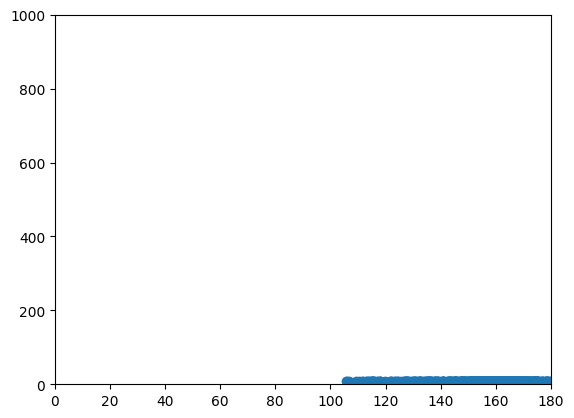

In [49]:
# plot
plt.scatter(x, y)
plt.ylim([0, 1000])     # restrict y axis to between 0 and 1000 (Newtons)
plt.xlim([0, 180])      # restrixt x axis to between 0 and 180 (degrees)

plt.show()

In [50]:
# check for maximum, for outlier identification
i,  = np.where(np.isclose(y, np.max(y)))
print(i)

[742]
